#  <center> Speech Emotion Recognition <center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
!pip install --upgrade librosa


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

from sklearn.svm import SVC

# to play the audio files
from IPython.display import Audio, display, Markdown

from sklearn.preprocessing import LabelEncoder

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
* I have merged emotions from four datasets into a single data frame, storing emotions along with their file paths.
* This data frame will streamline feature extraction for model training.
* This approach enhances efficiency and consistency in our speech-emotion recognition project.


In [ ]:
# Paths for data.

dir_path = '/content/drive/MyDrive/Speech emotion dataset/'
# dir_path = '/content/drive/MyDrive/SER Project/Speech emotion dataset/'

Ravdess = dir_path + "Ravdess/"
Crema = dir_path + "CREMA-D/"
Tess = dir_path + "Tess/"
Savee = dir_path + "SAVEE/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0      sad  /content/drive/MyDrive/Speech emotion dataset/...
1    happy  /content/drive/MyDrive/Speech emotion dataset/...
2    angry  /content/drive/MyDrive/Speech emotion dataset/...
3    angry  /content/drive/MyDrive/Speech emotion dataset/...
4    angry  /content/drive/MyDrive/Speech emotion dataset/...

## <center>2. Crema DataFrame</center>



In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0     fear  /content/drive/MyDrive/Speech emotion dataset/...
1      sad  /content/drive/MyDrive/Speech emotion dataset/...
2      sad  /content/drive/MyDrive/Speech emotion dataset/...
3  neutral  /content/drive/MyDrive/Speech emotion dataset/...
4    happy  /content/drive/MyDrive/Speech emotion dataset/...

##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0      fear  /content/drive/MyDrive/Speech emotion dataset/...
1       sad  /content/drive/MyDrive/Speech emotion dataset/...
2   disgust  /content/drive/MyDrive/Speech emotion dataset/...
3  surprise  /content/drive/MyDrive/Speech emotion dataset/...
4   disgust  /content/drive/MyDrive/Speech emotion dataset/...

##  <center> 4. SAVEE dataset <center>
The audio recordings in this collection have names with prefix letters that correspond to the following descriptions of the emotion classes:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/Speech emotion dataset/...
1    angry  /content/drive/MyDrive/Speech emotion dataset/...
2    angry  /content/drive/MyDrive/Speech emotion dataset/...
3    angry  /content/drive/MyDrive/Speech emotion dataset/...
4    angry  /content/drive/MyDrive/Speech emotion dataset/...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
merge_path = dir_path+"/merge dataset/merge_dataset.csv"
if not os.path.exists(merge_path):
  data_path.to_csv(merge_path,index=False)

data_path.head()

Emotions                                               Path
0      sad  /content/drive/MyDrive/Speech emotion dataset/...
1    happy  /content/drive/MyDrive/Speech emotion dataset/...
2    angry  /content/drive/MyDrive/Speech emotion dataset/...
3    angry  /content/drive/MyDrive/Speech emotion dataset/...
4    angry  /content/drive/MyDrive/Speech emotion dataset/...

In [ ]:
data_path.shape

(7848447, 2)

## Data Visualisation and Exploration

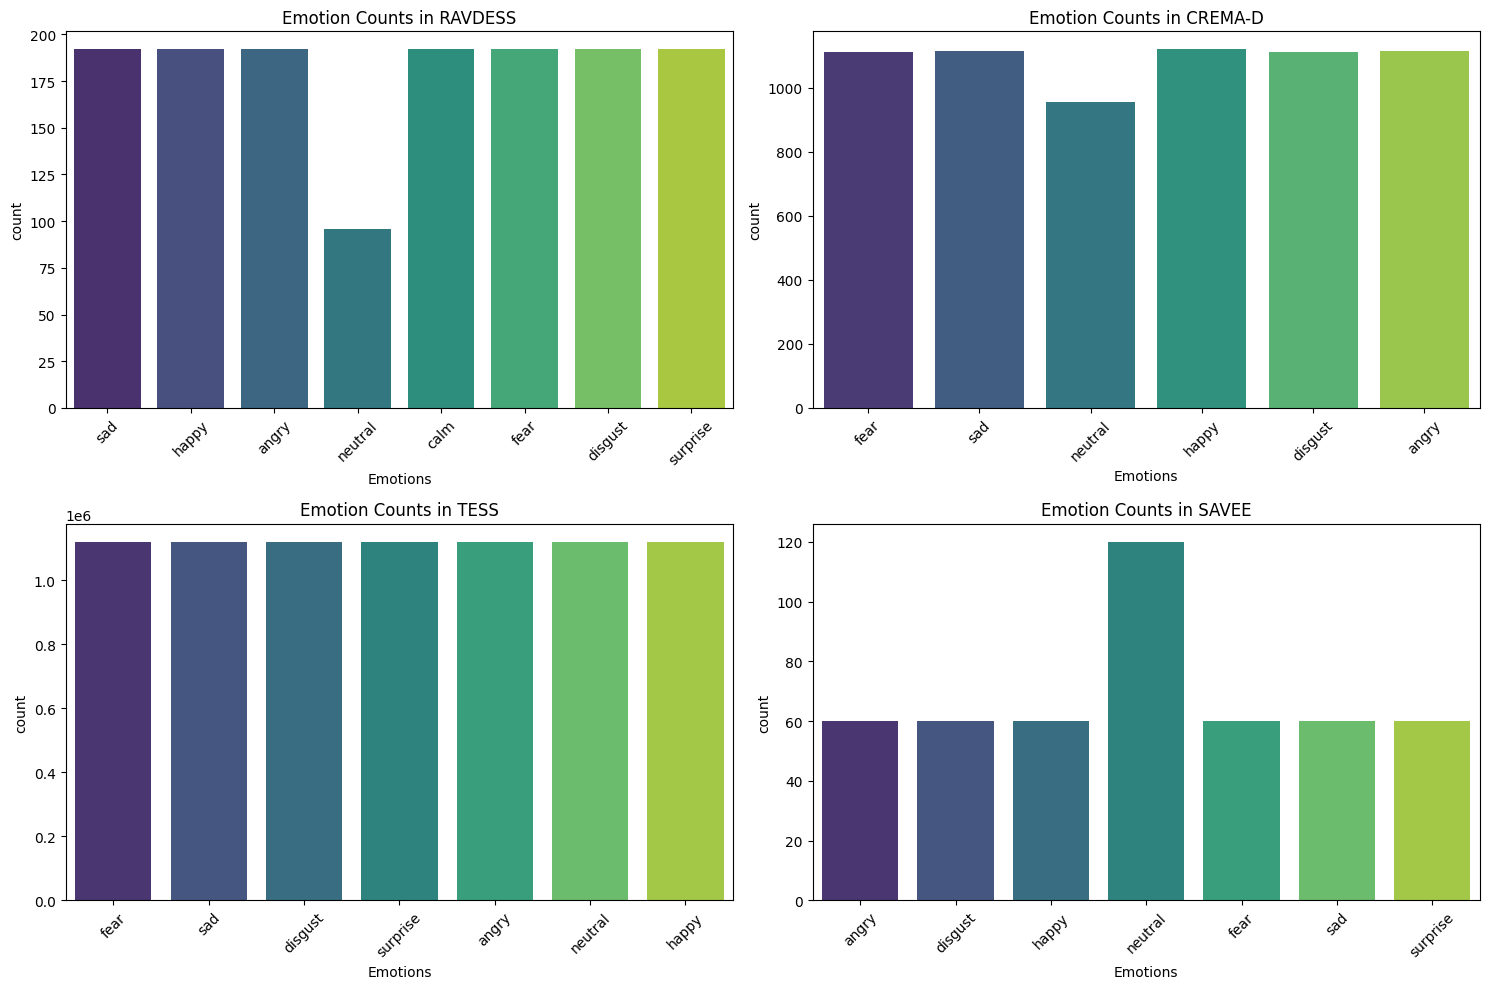

In [ ]:
datasets = [Ravdess_df, Crema_df, Tess_df, Savee_df]
dataset_names = ['RAVDESS', 'CREMA-D', 'TESS', 'SAVEE']

plt.figure(figsize=(15, 10))

for i, dataset in enumerate(datasets):
    plt.subplot(2, 2, i+1)
    sns.countplot(x='Emotions', data=dataset, palette='viridis')
    plt.title(f'Emotion Counts in {dataset_names[i]}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Plotting the number of each emotion in our dataset comes first.

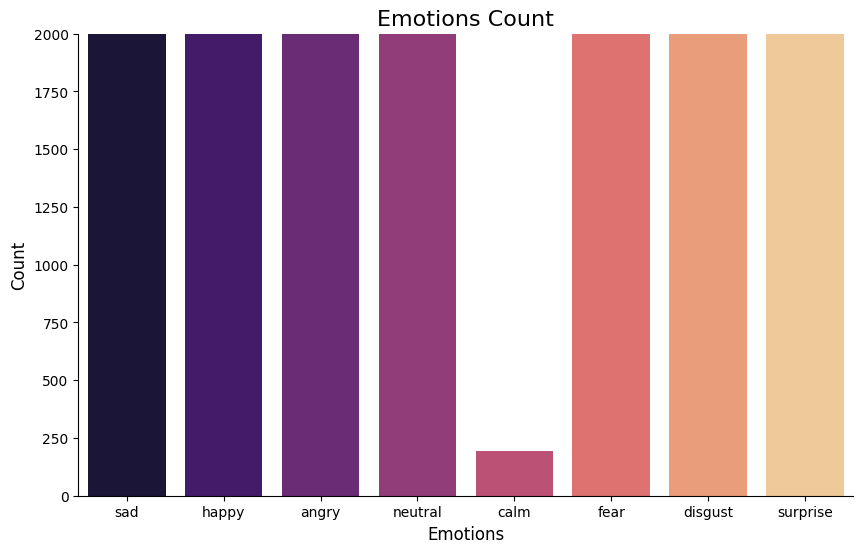

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Emotions Count', size=16)
sns.countplot(data=data_path, x='Emotions', palette='magma')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.ylim(0, 2000)
plt.show()

In [ ]:

# Calculate the counts of each emotion
emotion_counts = data_path['Emotions'].value_counts()

# Create a subplot with a single pie chart
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'pie'}]])

# Create the pie chart trace
trace = go.Pie(labels=emotion_counts.index, values=emotion_counts, hoverinfo='label+percent', textinfo='value')

# Add the trace to the subplot
fig.add_trace(trace)

# Update layout settings
fig.update_layout(title='Distribution of Emotions in Merged Dataset')

# Show the plot
fig.show()


In [ ]:
# Calculate the counts of each emotion
emotion_counts = data_path['Emotions'].value_counts()

# Create a subplot with a single bar plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'bar'}]])

# Create the bar plot trace
trace = go.Bar(x=emotion_counts.index, y=emotion_counts, text=emotion_counts, textposition='auto', marker_color='peru')

# Add the trace to the subplot
fig.add_trace(trace)

# Update layout settings
fig.update_layout(title='Distribution of Emotions in Merged Dataset', yaxis_type="log")

# Show the plot
fig.show()


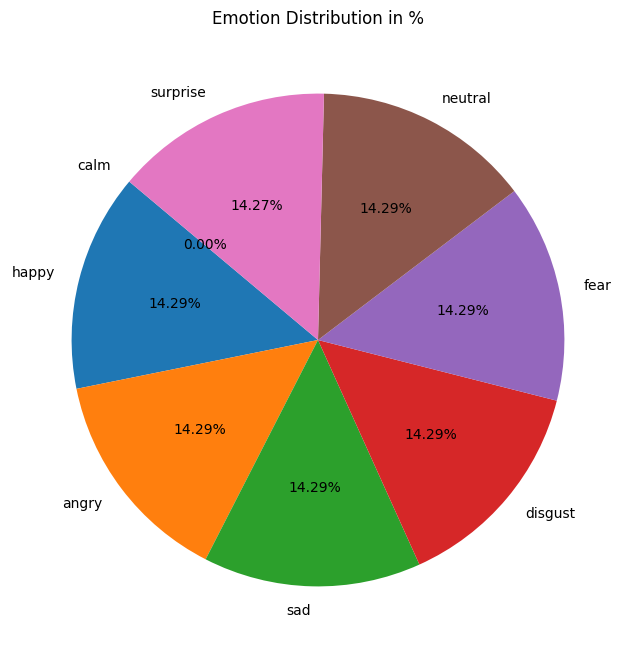

In [ ]:
# Set a threshold for displaying slices
threshold = 100

# Filter emotions based on the threshold
filtered_emotions = data_path['Emotions'].value_counts().loc[lambda x: x >= threshold]



# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(filtered_emotions, labels=filtered_emotions.index, autopct='%1.2f%%', startangle=140)
plt.title('Emotion Distribution in %')
plt.show()


For audio signals, we can also create wave plots and spectrograms.
* Wave plots: Wave plots reveal the volume of the audio at a certain moment.
* A spectrogram is a visual depiction of the frequency spectrum of sound or other signals as it varies over time. It shows how the frequencies of specific audio and music signals change over time.

In [ ]:
def create_waveplot(data, sr, e, color):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr, color=color)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

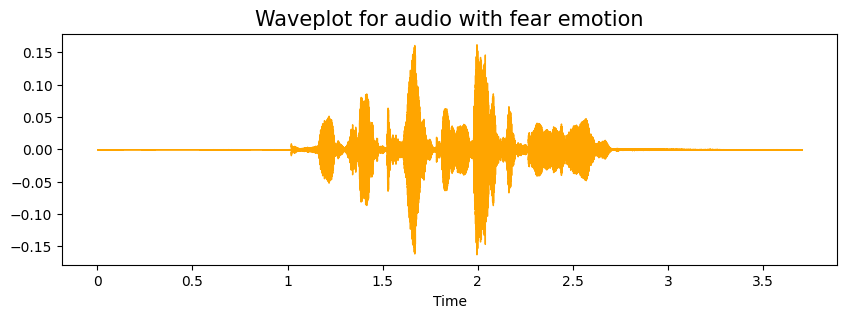

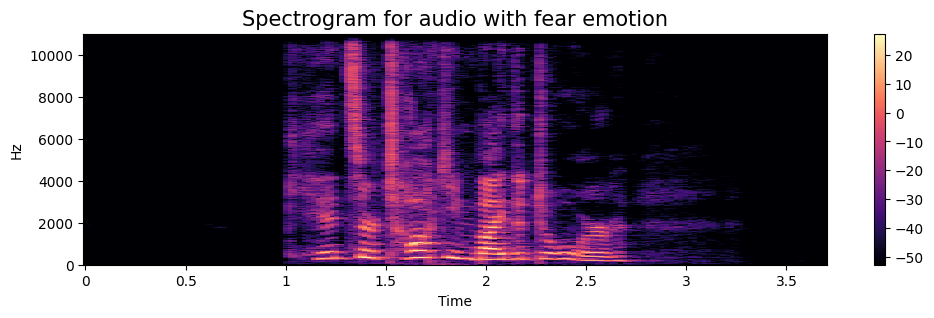

In [ ]:
emotion='fear'
color = 'orange'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, color)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

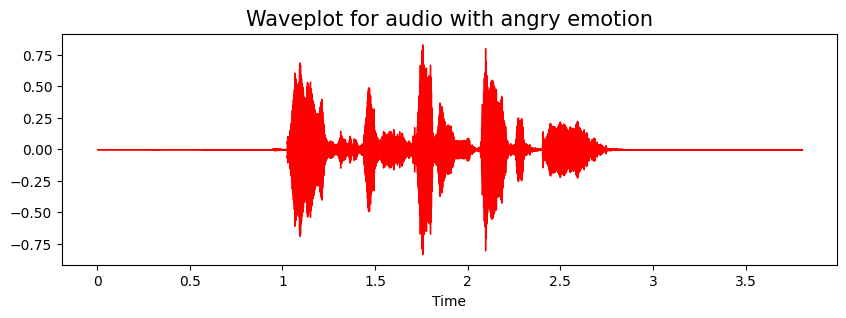

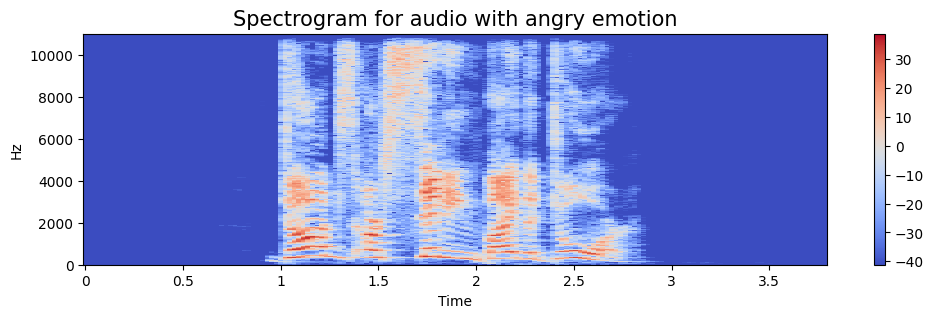

In [ ]:
emotion='angry'
color = 'red'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, color)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

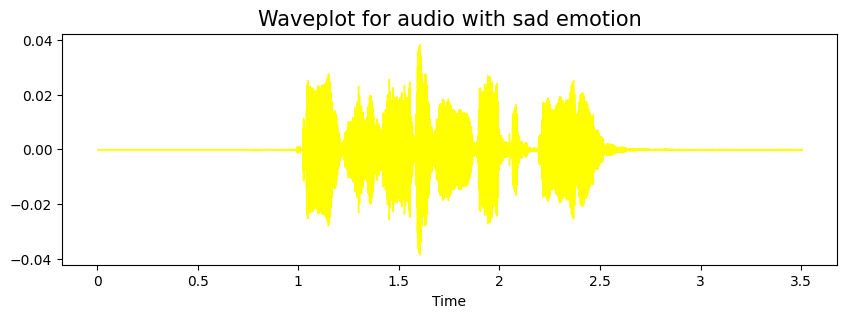

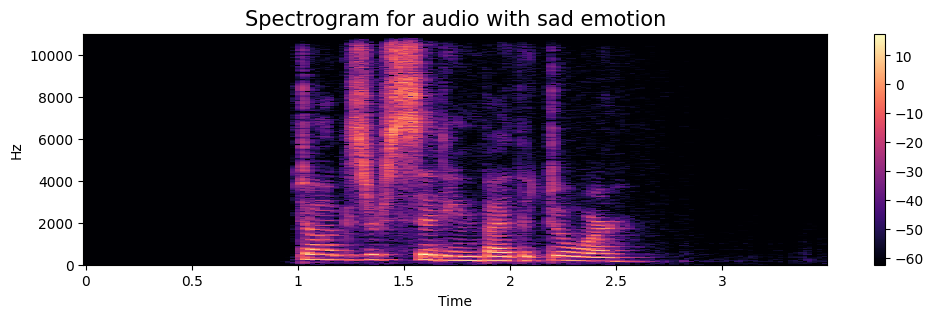

In [ ]:
emotion='sad'
color = 'yellow'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, color)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

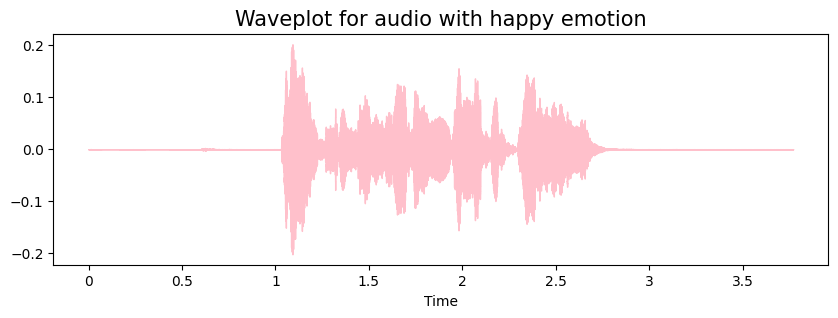

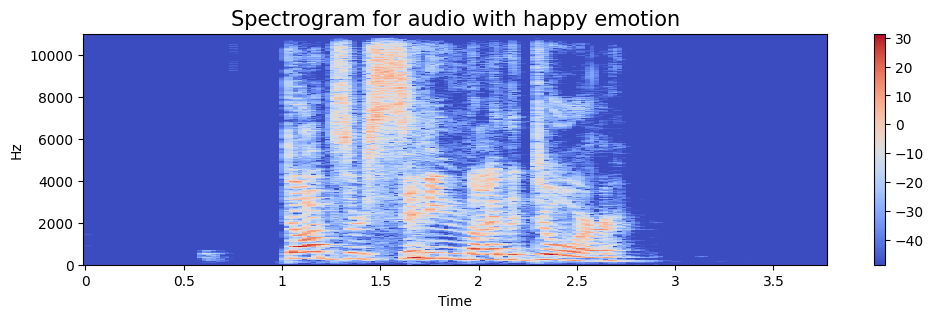

In [ ]:
emotion='happy'
color = 'pink'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion, color)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

By adding minor changes to our initial training set, we can generate fresh synthetic data samples, a technique known as data augmentation.
* We can use noise injection, time shifting, pitch and speed changes, and other techniques to produce syntactic data for audio.
* Making our model resistant to these perturbations will increase its generalizability.
* The label from the initial training sample must be preserved when adding the perturbations for this to work.
* Data enhancement in photos can be done by rotating, zooming, and shifting the image.
* Let's first determine which augmentation strategies fit our dataset the best.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

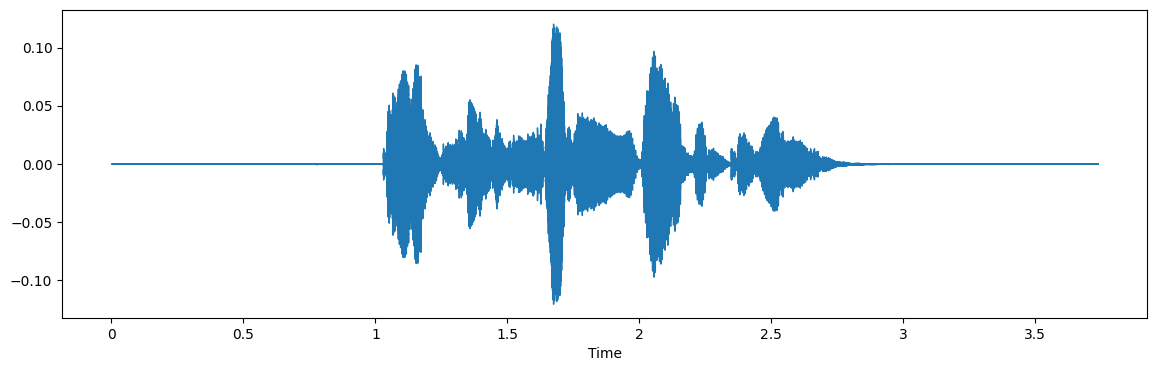

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

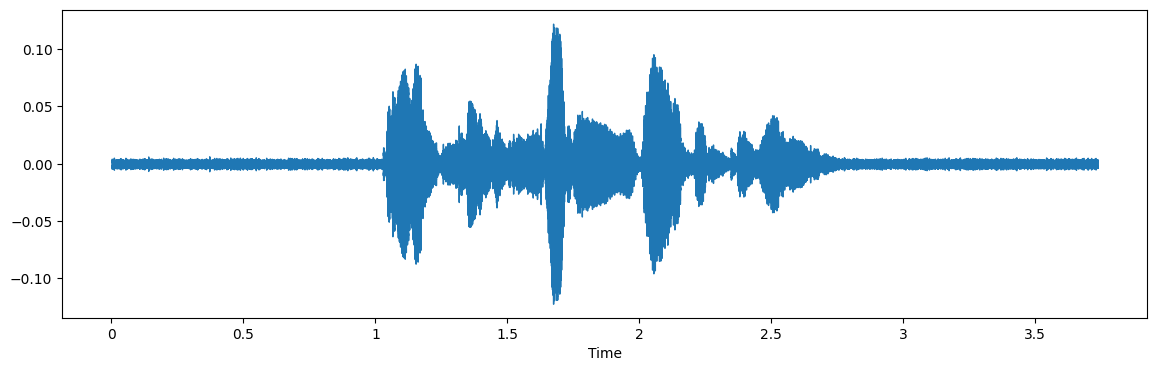

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

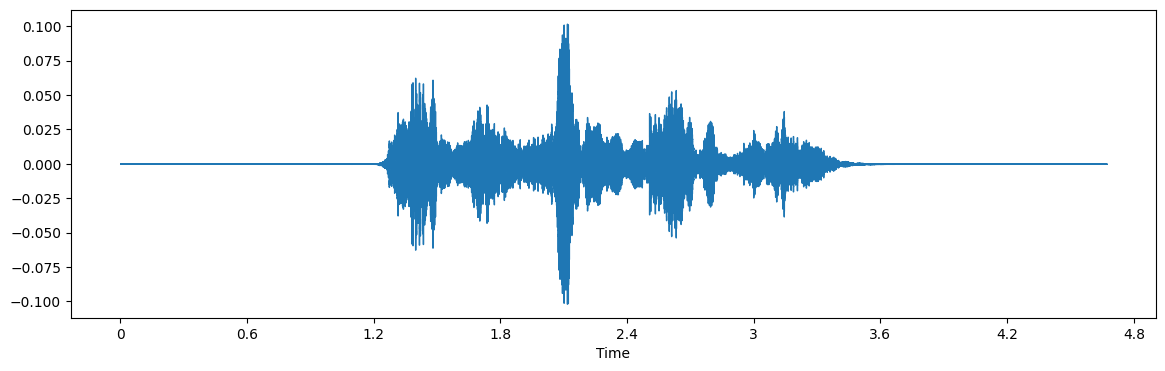

In [ ]:
x = stretch(data, rate=0.7)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

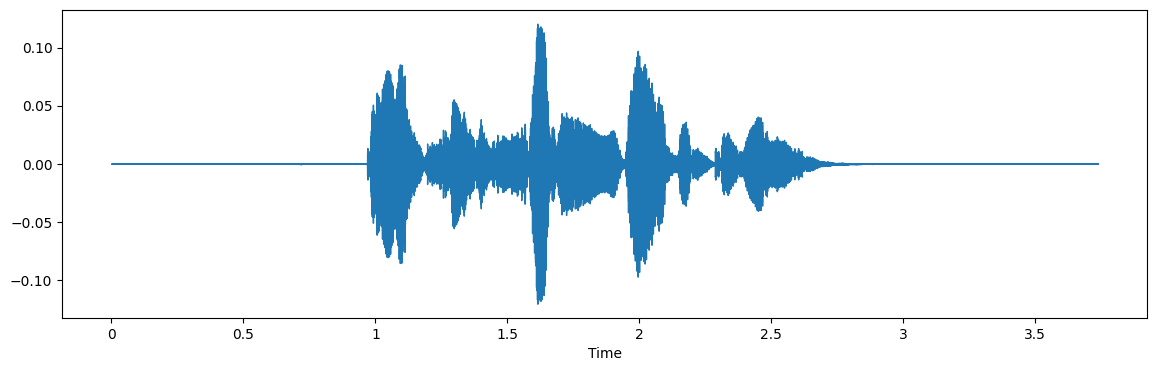

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

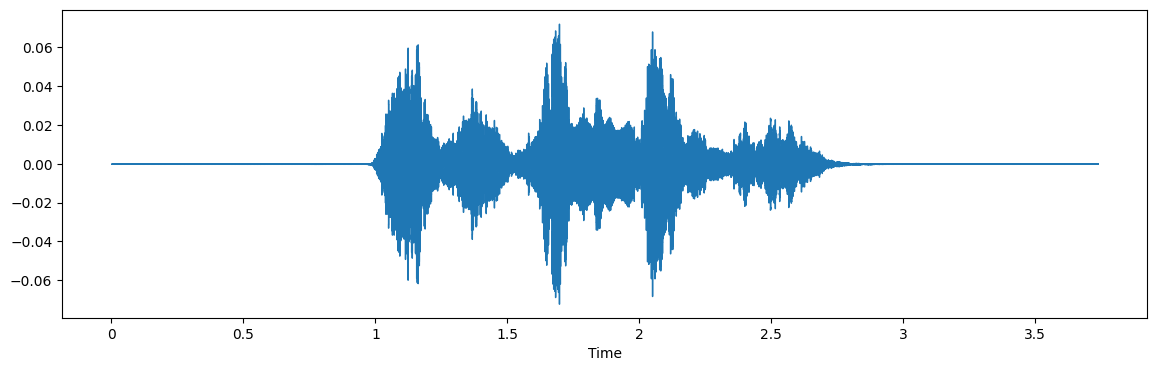

In [ ]:
pitch_steps=3
x=pitch(data, sample_rate, n_steps=pitch_steps)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

As augmentation techniques,

I'm using pitch manipulation, speed stretching, and noise addition in my project.

## Feature Extraction
* A crucial step in analysing and discovering relationships between various things is feature extraction. We need to convert the audio data presented into a format that the models can interpret because, as we already know, they cannot do it directly. To do this, feature extraction is required.
* The three axes of the audio signal—time, amplitude, and frequency—represent its three dimensions.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

There are a few features extraction methods used in this project, which are as follows
*	Zero Crossing Rate
*	Chroma_stft
*	MFCC
*	RMS(root mean square) value
*	MelSpectogram to train our model.

Every audio file's features were extracted via data augmentation, and then they were saved.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data, rate=0.8)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
# Define the number of samples per emotion
samples_per_emotion = 10

# Initialize lists to store features and labels
X = []
Y = []

# Iterate through all emotions and sample the specified number of samples per emotion
for emotion in data_path['Emotions'].unique():
    emotion_samples = data_path[data_path['Emotions'] == emotion].sample(n=samples_per_emotion, random_state=42)
    for _, row in emotion_samples.iterrows():
        path = row['Path']
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)

# Convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)



In [ ]:
len(X), len(Y), data_path.Path.shape

(240, 240, (7848447,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv(dir_path+'/output-features/features.csv', index=False)
Features

0         1         2         3         4         5         6  \
0    0.059930  0.366072  0.423636  0.320402  0.273094  0.307936  0.447564   
1    0.142090  0.508897  0.438318  0.399226  0.437175  0.525342  0.609715   
2    0.080775  0.365687  0.256526  0.364741  0.433921  0.283547  0.216178   
3    0.046799  0.459731  0.445196  0.331483  0.339976  0.345963  0.430458   
4    0.084930  0.526722  0.454366  0.386412  0.410023  0.427327  0.491461   
..        ...       ...       ...       ...       ...       ...       ...   
235  0.104173  0.555546  0.479848  0.414533  0.426474  0.433487  0.452081   
236  0.100388  0.566446  0.518797  0.439453  0.345396  0.335067  0.366692   
237  0.054034  0.281937  0.301459  0.396272  0.453130  0.440008  0.483218   
238  0.138589  0.436094  0.448500  0.517063  0.574247  0.554104  0.526868   
239  0.064099  0.407594  0.365559  0.313995  0.291945  0.364410  0.451357   

            7         8         9  ...       153       154       155  \
0    0.562237  0.397351  0.369483  ...  0.000950  0.000854  0.000574   
1    0.483786  0.428598  0.570331  ...  0.003141  0.003235  0.002939   
2    0.264984  0.389185  0.551654  ...  0.000252  0.000283  0.000290   
3    0.470644  0.473860  0.601882  ...  0.000066  0.000098  0.000110   
4    0.482581  0.528047  0.633499  ...  0.000311  0.000326  0.000334   
..        ...       ...       ...  ...       ...       ...       ...   
235  0.531344  0.536466  0.612846  ...  0.001343  0.001074  0.001013   
236  0.398099  0.531935  0.566156  ...  0.000096  0.000109  0.000076   
237  0.589575  0.657253  0.580018  ...  0.000005  0.000008  0.000011   
238  0.605902  0.695272  0.703607  ...  0.000503  0.000474  0.000495   
239  0.426274  0.422864  0.531044  ...  0.000006  0.000002  0.000002   

          156           157       158       159       160           161  \
0    0.000480  2.964341e-04  0.000169  0.000130  0.000063  3.557263e-06   
1    0.002582  2.459614e-03  0.002458  0.002466  0.002374  2.260817e-03   
2    0.000244  2.460165e-04  0.000234  0.000140  0.000060  5.079199e-06   
3    0.000083  7.286773e-05  0.000060  0.000066  0.000032  2.144889e-06   
4    0.000300  3.005277e-04  0.000287  0.000286  0.000253  2.292713e-04   
..        ...           ...       ...       ...       ...           ...   
235  0.000868  7.330476e-04  0.000589  0.000564  0.000520  5.157837e-04   
236  0.000090  1.402335e-04  0.000188  0.000193  0.000078  4.391517e-06   
237  0.000005  2.902498e-06  0.000003  0.000002  0.000001  1.089821e-07   
238  0.000528  5.167843e-04  0.000517  0.000522  0.000512  4.912106e-04   
239  0.000001  7.975963e-07  0.000001  0.000002  0.000001  5.971457e-08   

       labels  
0         sad  
1         sad  
2         sad  
3         sad  
4         sad  
..        ...  
235  surprise  
236  surprise  
237  surprise  
238  surprise  
239  surprise  

[240 rows x 163 columns]

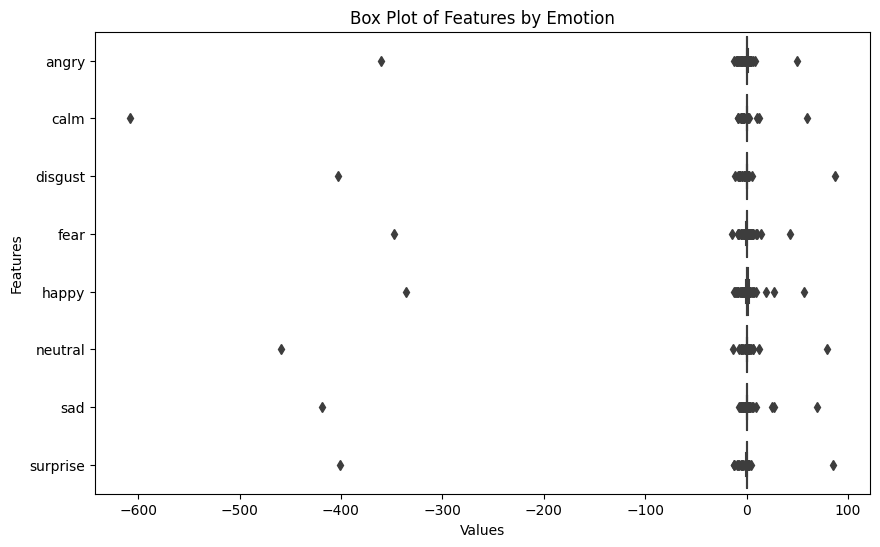

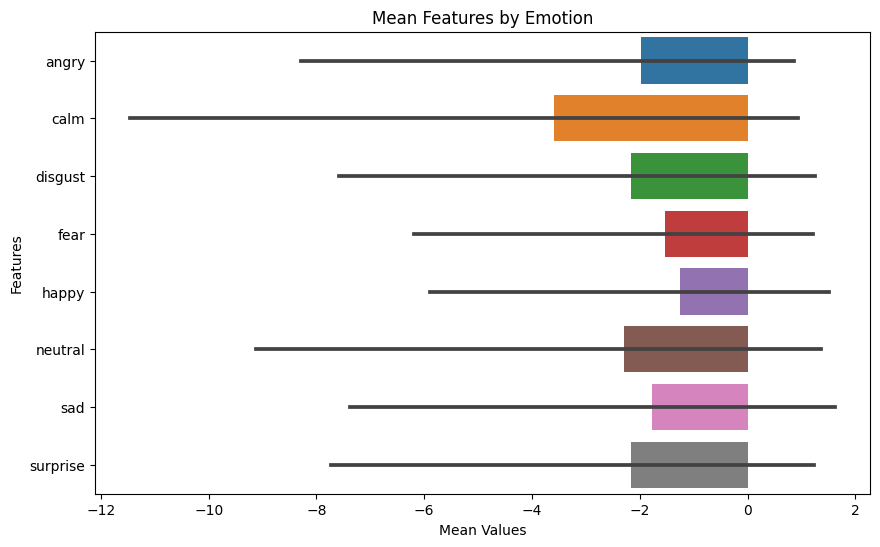

In [ ]:
# Group by 'labels' and calculate mean values for features
agg_data = Features.groupby('labels').mean()

# Create box plots for each feature using aggregated data
plt.figure(figsize=(10, 6))
sns.boxplot(data=agg_data.T, orient='h')
plt.title('Box Plot of Features by Emotion')
plt.xlabel('Values')
plt.ylabel('Features')
plt.show()

# Create bar plots for each feature using aggregated data
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_data.T, orient='h')
plt.title('Mean Features by Emotion')
plt.xlabel('Mean Values')
plt.ylabel('Features')
plt.show()


* I have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation and Preprocessing

- As of now I have extracted the data, now I normalized and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162), (180, 8), (60, 162), (60, 8))

In [ ]:
from sklearn.preprocessing import RobustScaler

# scaling our data with sklearn's Standard scaler
scaler = RobustScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162), (180, 8), (60, 162), (60, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162, 1), (180, 8), (60, 162, 1), (60, 8))

##Modelling

In [ ]:
# Flatten one-hot encoded labels for SVM
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

# Reshape data back to two dimensions
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

#**SVM Model**

In [ ]:
from prettytable import PrettyTable

# Initialize PrettyTable object
table = PrettyTable()

# Define column names
table.field_names = ["C Value", "Test Data Accuracy (%)"]

# List of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Loop to train model with different C values
for C_val in C_values:

    # Create and train the SVM model with a linear kernel
    svm_model = SVC(kernel='linear', C=C_val, probability=True)
    svm_model.fit(x_train, y_train_svm)

    # Evaluate the SVM model
    y_pred_svm = svm_model.predict(x_test)
    accuracy = accuracy_score(y_test_svm, y_pred_svm) * 100

    # Add the results to the table
    table.add_row([C_val, f"{accuracy:.2f}"])

# Print the table
print(table)


+---------+------------------------+
| C Value | Test Data Accuracy (%) |
+---------+------------------------+
|  0.001  |         41.67          |
|   0.01  |         71.67          |
|   0.1   |         83.33          |
|    1    |         83.33          |
|    10   |         83.33          |
|   100   |         83.33          |
+---------+------------------------+


Accuracy on test data:  83.33%


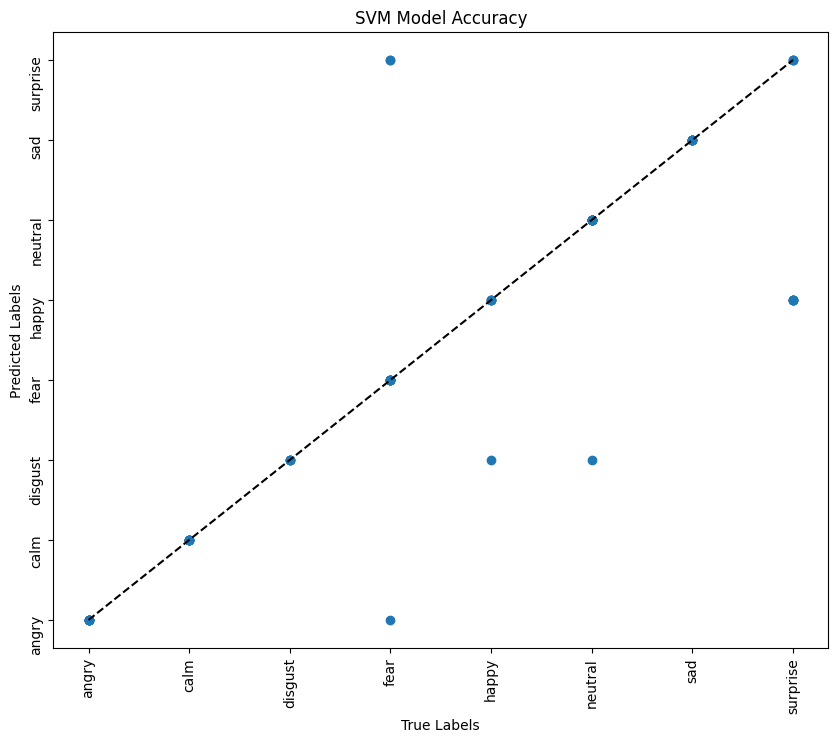

In [ ]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', C=0.1, probability=True)
svm_model.fit(x_train, y_train_svm)

# Evaluate the SVM model
accuracy = svm_model.score(x_test, y_test_svm)
print(f"Accuracy on test data: {accuracy*100: .2f}%")

# Plotting scatter plot for predicted labels vs. true labels
plt.figure(figsize=(10, 8))
plt.scatter(y_test_svm, svm_model.predict(x_test))
plt.plot([0, np.max(y_test_svm)], [0, np.max(y_test_svm)], 'k--')
plt.title('SVM Model Accuracy')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

encoder = LabelEncoder()
encoder.fit(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

# Set x-axis ticks to class labels
tick_positions = np.arange(len(encoder.classes_))
plt.xticks(tick_positions, encoder.classes_, rotation='vertical')
plt.yticks(tick_positions, encoder.classes_, rotation='vertical')

plt.show()

In [ ]:
# Predicting on test data
pred_test = svm_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_svm, pred_test)
print(f"Accuracy of SVM: {accuracy*100: .2f}%")

# Get the class labels in the order from the encoder
class_labels = encoder.classes_

# Map numerical labels to class labels
y_pred_labels = np.array([class_labels[label] for label in pred_test])
y_actual_labels = np.array([class_labels[label] for label in y_test_svm])

# Create a DataFrame to compare predicted and actual labels
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels
df['Actual Labels'] = y_actual_labels

# Display the DataFrame with dashed borders
display(Markdown("**DataFrame of Predicted and Actual Labels**"))

# Function to display DataFrame with dashed borders
def display_df_with_borders(df):
    border_style = "border: 1px dashed black;"
    df_styled = df.style.set_properties(**{'border-collapse': 'collapse', 'border': '1px dashed black'}).set_table_styles([{'selector': '', 'props': [('border', border_style)]}])
    display(df_styled)

# Display the formatted DataFrame
display_df_with_borders(df.head(20))





Accuracy of SVM:  86.67%


**DataFrame of Predicted and Actual Labels**

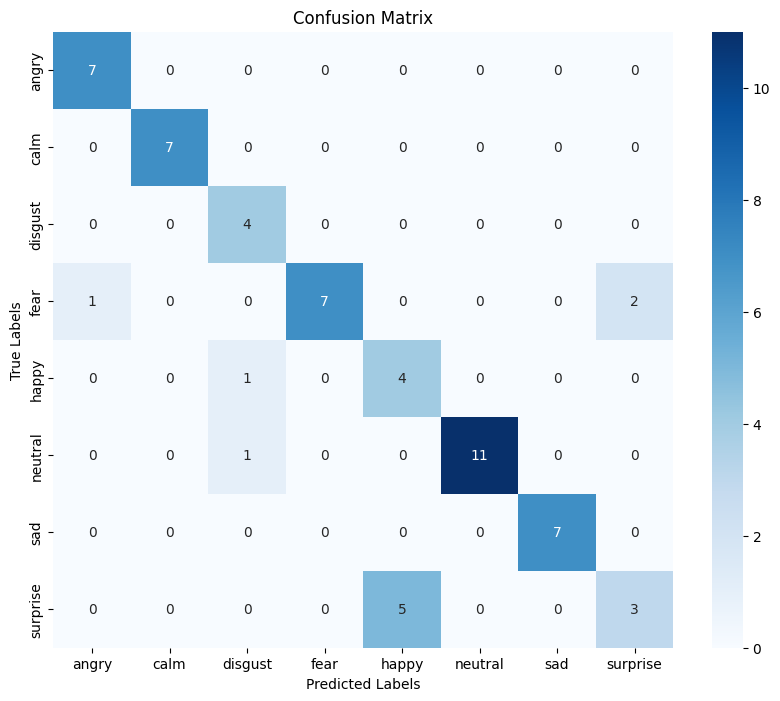

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_svm, svm_model.predict(x_test))

# Get class labels from encoder
class_labels = [f"{label}" for label in encoder.classes_]

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# CNN Model

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162), (180, 8), (60, 162), (60, 8))

In [ ]:
from sklearn.preprocessing import RobustScaler

# scaling our data with sklearn's Standard scaler
scaler = RobustScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162), (180, 8), (60, 162), (60, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((180, 162, 1), (180, 8), (60, 162, 1), (60, 8))

In [ ]:
# Reshape data back to two dimensions
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

## Final model tuning code

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.0001)

# Model architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilation
optimizer_adam = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Model training
history = model.fit(
    x_train,
    y_train,
    batch_size=256,  # Adjusted batch size
    epochs=50,  # Increased epochs
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],  # Added callbacks
    verbose=1
)

plot_model(model, to_file='/content/drive/MyDrive/Speech emotion dataset/cnn_model_architecture.png', show_shapes=True, show_layer_names=True)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final accuracy on test data: {model.evaluate(x_test, y_test)[1]*100:.2f}%")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 81, 64)            0         
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 64)                331840    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
y_train.shape, y_test.shape

((180, 8), (60, 8))

2/2 [==============================] - 0s 17ms/step - loss: 0.3047 - accuracy: 0.9000
Accuracy of CNN model on test data : 90.00 %


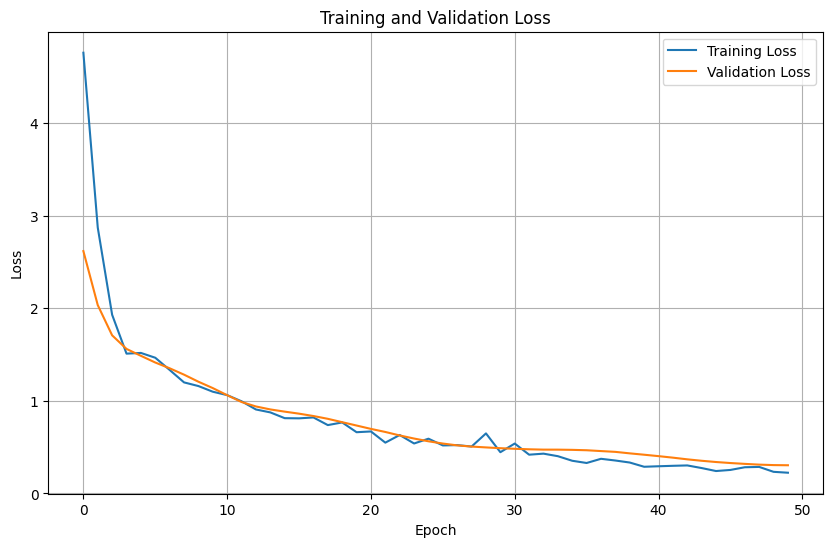

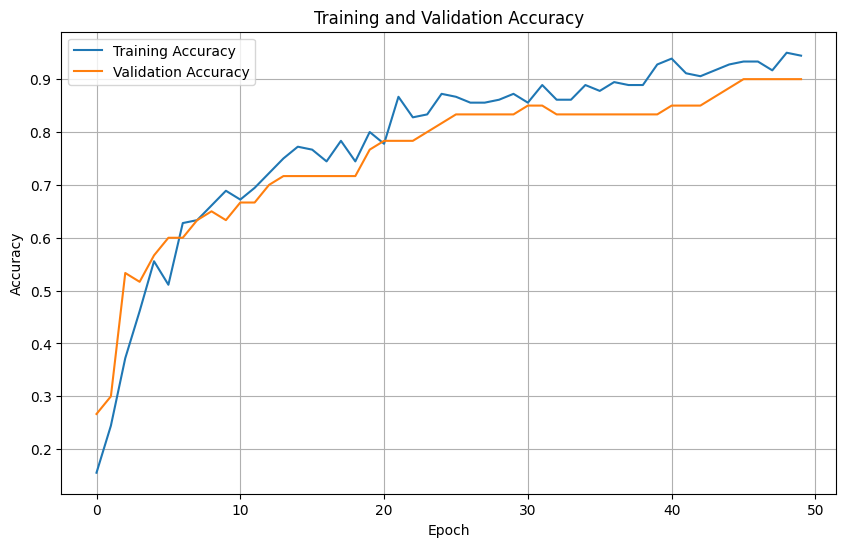

In [ ]:
print(f"Accuracy of CNN model on test data : {model.evaluate(x_test,y_test)[1]*100 :.2f} %")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# Plot the accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
  # predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

2/2 [==============================] - 0s 8ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

# Display the DataFrame with dashed borders
display(Markdown("**DataFrame of Predicted and Actual Labels**"))

# Display the formatted DataFrame
display_df_with_borders(df.head(20))


**DataFrame of Predicted and Actual Labels**

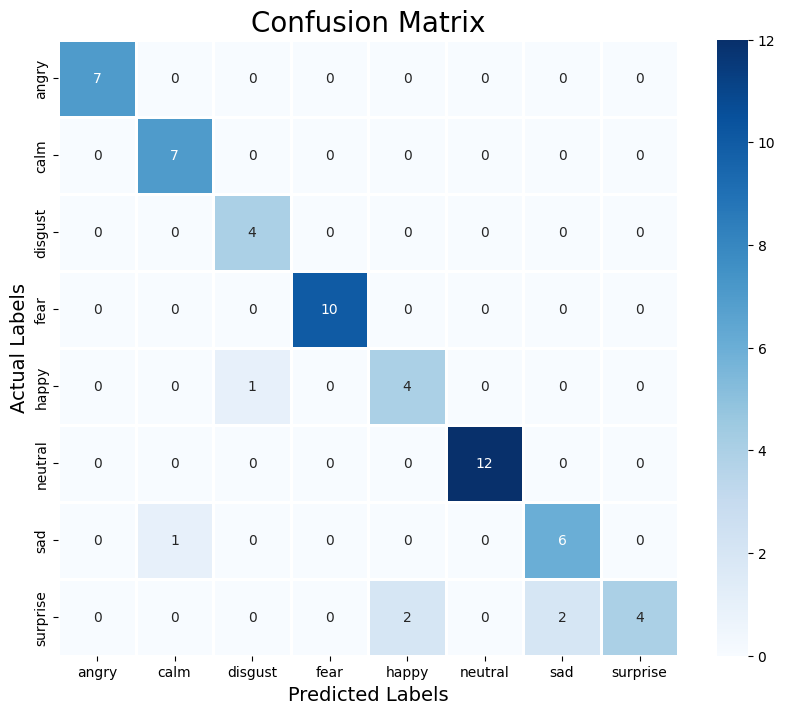

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique class labels from your test data
unique_classes = np.unique(np.concatenate((y_test, y_pred)))

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:

display(Markdown("<b>&emsp;&emsp;&emsp;&emsp;Classification Report</b>"))
print(classification_report(y_test, y_pred))

<b>&emsp;&emsp;&emsp;&emsp;Classification Report</b>

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00         7
        calm       0.88      1.00      0.93         7
     disgust       0.80      1.00      0.89         4
        fear       1.00      1.00      1.00        10
       happy       0.67      0.80      0.73         5
     neutral       1.00      1.00      1.00        12
         sad       0.75      0.86      0.80         7
    surprise       1.00      0.50      0.67         8

    accuracy                           0.90        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.92      0.90      0.89        60



- Our model demonstrates higher accuracy in discerning surprise, anger, fear, and neutrality, which aligns with the distinct audio characteristics associated with these emotions, such as pitch and speed variations.
- We have attained an overall 90% accuracy rate on our test dataset, which is commendable. Nevertheless, there is room for enhancement through the incorporation of additional augmentation strategies and the exploration of alternative feature extraction approaches.